# Init

In [1]:
%matplotlib inline

import os
import arrow
import pickle
import pandas as pd
from IPython.display import clear_output

import cfg4py
import omicron
import numpy as np
from omicron.core.types import FrameType
from omicron.models.securities import Securities
from omicron.models.security import Security

from alpha.core.features import predict_by_moving_average, moving_average,fillna
from alpha.plotting import draw_trendline
from alpha.config import get_config_dir
from alpha.strategies.twins import Twins
from alpha.core.morph import MorphFeatures

cfg4py.init(get_config_dir())
await omicron.init()


try:
    twins  = Twins.load("/root/alpha/data/twins/twins-v1.pkl")
except Exception:
    twins = Twins("v1")
    
clear_output()

# 加载数据

In [2]:
with open("/data/stocks/ds_even_30m_300_5000.pkl", "rb") as f:
    ds = pickle.load(f)

In [3]:
df = pd.DataFrame(ds["data"], columns=["code", "y", "bars"])

In [ ]:
def ylabel(bars):
    ybars= bars[-5:]
    yclose = ybars["close"][-5:]
    c0 = bars["close"][-6]
    
    max_adv = max(yclose) / c0 - 1
    max_dec = abs(min(yclose) / c0 - 1)
    
    agg = max if max_adv > max_dec else min
    
    return agg(yclose) / c0 - 1
    
df.y = df.bars.apply(lambda x: ylabel(x))

In [ ]:
df[df.y>0.1]

ma5 pred: [60.507428596133266, 60.68871419997437, 60.86257120768219, 61.02899961925679, 61.1879994346981]
ma10 pred: [60.69850113261829, 60.9473263740539, 61.19949254469427, 61.45499964453952, 61.71384767358943]
ma20 pred: [61.280934007818104, 61.65135260264062, 62.04000481461016, 62.44689064372651, 62.87201008998968]
ma60 pred: [61.853220731562274, 62.350659368014156, 62.85069775196097, 63.35333588340089, 63.85857376233527]


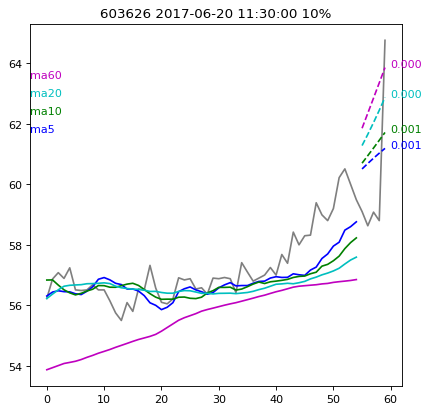

In [13]:
def draw(i):
    code, y, bars = df.loc[i]
    xend = bars["frame"][-6]
    desc = f"{code.split('.')[0]} {str(xend).replace('+08:00', '')} {y:.0%}"
    draw_trendline(bars["close"], 5, save_to = f"/data/twins/{code}.jpg", desc=desc)
    
for i in df[df.y>0.1].index:
    draw(i)
    break

In [11]:
code, y, bars = df.loc[625]
close = bars["close"]
print(code, close[-6:])
predict_by_moving_average(close[:-5], 10, 5)

603626.XSHG [59.49 59.1  58.63 59.08 58.8  64.76]


([60.69850113261829,
  60.9473263740539,
  61.19949254469427,
  61.45499964453952,
  61.71384767358943],
 0.0005662935193783736)

# build morph库

In [ ]:
m = MorphFeatures(FrameType.DAY)

def add_pattern(bars):
    for i in range(220):
        close = bars["close"][i:i+81]
        if np.count_nonzero(np.isfinite(close)) < 81*0.9:
            continue
            
        close = fillna(close.copy())
        m.encode(close)

df.bars.apply(add_pattern)
m.dump()

# 增加样本

In [ ]:
twins.add_pattern()